In [6]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
from urllib.parse import urlparse

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

In [18]:
domain_index = pd.read_csv('../02_data/data_archive/raphaela/lasser/domain_pc1.csv')
chat_index = np.load('../02_data/telegram/telegram/chat_index.npy')
urls_sample = pd.read_csv('../02_data/url_sample_with_titles.csv')

In [7]:
# urls = pd.read_csv('../02_data/urls_with_titles.csv')

In [19]:
print("Chat Index Shape:", chat_index.shape)
print(urls_sample.head())

Chat Index Shape: (27592,)
         id                                                url  \
0  31404053  https://www.indiatoday.in/india/story/wrestler...   
1  52148717  https://bigota.d.miui.com/V13.0.3.0.SKGINXM/mi...   
2  18230339  https://www.washingtonpost.com/religion/2019/0...   
3  25932375  https://www.news24.com/fin24/companies/mining/...   
4  22284125  https://www.aljazeera.com/economy/2021/7/15/us...   

                   start_date                    end_date  \
0  2023-05-04 09:33:21.000000  2023-05-04 09:33:21.000000   
1  2022-09-09 03:09:19.000000  2022-09-09 03:09:19.000000   
2  2019-05-02 03:59:48.000000  2019-05-03 17:27:26.000000   
3  2021-09-21 06:12:02.000000  2021-09-21 06:12:02.000000   
4  2021-07-15 23:08:07.000000  2021-07-15 23:08:07.000000   

                                               title  
0  wrestlers protest vinesh phogat emotional prot...  
1  miui blockota mojito in global V13.0.2.0.SKGIN...  
2  alleged synagogue shooter was churchgoer 

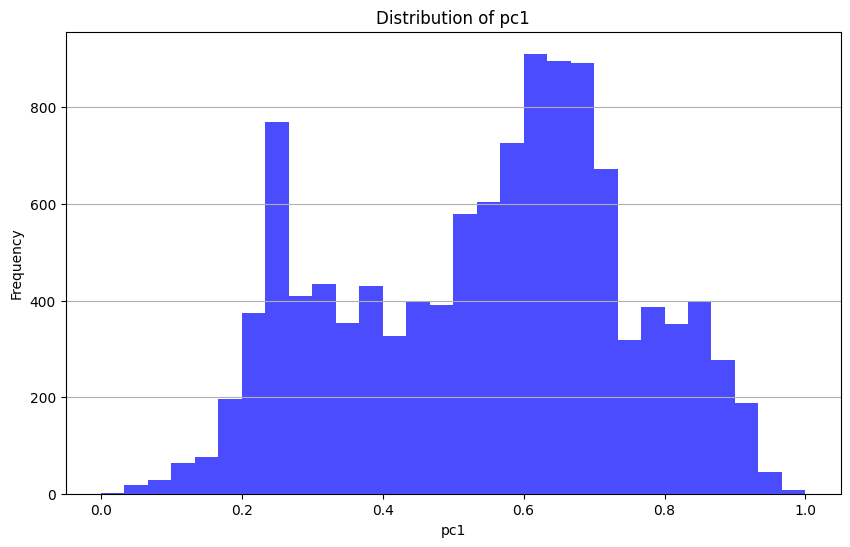

Top 5 rows with the highest pc1 scores:
                 domain       pc1
0           reuters.com  1.000000
1            apnews.com  0.998049
2  charitynavigator.org  0.985752
3          rollcall.com  0.982851
4    smithsonianmag.com  0.971184

Bottom 5 rows with the lowest pc1 scores:
                domain       pc1
11519  naturalnews.com  0.000000
11518    worldtruth.tv  0.017644
11517    davidicke.com  0.041614
11516    pandemic.news  0.043817
11513        rense.com  0.044752


In [20]:
# Plot the distribution of the 'pc1' column
plt.figure(figsize=(10, 6))
plt.hist(domain_index['pc1'], bins=30, color='blue', alpha=0.7)
plt.title('Distribution of pc1')
plt.xlabel('pc1')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

# Show the row with the highest 'pc1' score
highest_scores = domain_index.nlargest(5, 'pc1')
print("Top 5 rows with the highest pc1 scores:")
print(highest_scores)

# Show the 5 rows with the lowest 'pc1' scores
lowest_scores = domain_index.nsmallest(5, 'pc1')
print("\nBottom 5 rows with the lowest pc1 scores:")
print(lowest_scores)


In [21]:
# Extract domain from URL 
def extract_domain(url):
    try:
        parsed_url = urlparse(url)
        return parsed_url.netloc
    except Exception as e:
        print(f"Error parsing URL: {url} - {e}")
        return None

# Apply the function to extract the domain and handle any errors
urls_sample['domain'] = urls_sample['url'].apply(extract_domain)

# Display the first few rows with the extracted domain
print("URLs Sample with Domain:\n", urls_sample.head())

URLs Sample with Domain:
          id                                                url  \
0  31404053  https://www.indiatoday.in/india/story/wrestler...   
1  52148717  https://bigota.d.miui.com/V13.0.3.0.SKGINXM/mi...   
2  18230339  https://www.washingtonpost.com/religion/2019/0...   
3  25932375  https://www.news24.com/fin24/companies/mining/...   
4  22284125  https://www.aljazeera.com/economy/2021/7/15/us...   

                   start_date                    end_date  \
0  2023-05-04 09:33:21.000000  2023-05-04 09:33:21.000000   
1  2022-09-09 03:09:19.000000  2022-09-09 03:09:19.000000   
2  2019-05-02 03:59:48.000000  2019-05-03 17:27:26.000000   
3  2021-09-21 06:12:02.000000  2021-09-21 06:12:02.000000   
4  2021-07-15 23:08:07.000000  2021-07-15 23:08:07.000000   

                                               title                  domain  
0  wrestlers protest vinesh phogat emotional prot...       www.indiatoday.in  
1  miui blockota mojito in global V13.0.2.0.SKGIN...

In [22]:
# Step 2: Match domains with domain_index
urls_sample = pd.merge(urls_sample, domain_index, on='domain', how='inner')

# Display the first few rows of the merged DataFrame
print(urls_sample.head())

# Drop rows where the domain was not found in domain_index
urls_sample.dropna(subset=['pc1'], inplace=True)

         id                                                url  \
0  16813965  https://rumble.com/v11uxz5-president-trump-bus...   
1   8937464  https://gender.news/2019-05-22-democrats-passa...   
2  12896181  https://amgreatness.com/2022/06/28/top-gun-mav...   
3  19933646  https://nypost.com/2023/01/06/passenger-hauled...   
4  10915134  https://nypost.com/2023/06/21/former-nfl-steel...   

                   start_date                    end_date  \
0  2022-04-22 07:29:05.000000  2022-04-22 07:29:05.000000   
1  2019-06-18 05:40:34.000000  2019-06-18 05:40:34.000000   
2  2022-06-29 18:03:58.000000  2023-08-21 20:27:56.389222   
3  2023-01-06 19:34:07.000000  2023-01-06 19:34:07.000000   
4  2023-06-21 07:35:00.000000  2023-08-29 17:08:37.212656   

                                               title           domain  \
0  v11uxz5 president trump busted piers morgan. m...       rumble.com   
1  2019 05 22 democrats passage of equality act a...      gender.news   
2                

In [23]:
# Assuming chat_index corresponds to rows in urls_sample, add it to the DataFrame - this is RANDOM
urls_sample['chat_idx'] = chat_index[:len(urls_sample)]

In [24]:
urls_sample['start_date'] = pd.to_datetime(urls_sample['start_date'])

urls_sample['start_year'] = urls_sample['start_date'].dt.year
urls_sample['start_month'] = urls_sample['start_date'].dt.month
urls_sample['start_day'] = urls_sample['start_date'].dt.day
urls_sample['start_hour'] = urls_sample['start_date'].dt.hour

In [25]:
urls_sample

,id,url,start_date,end_date,title,domain,pc1,chat_idx,start_year,start_month,start_day,start_hour
0,16813965,https://rumble.com/v11uxz5-president-trump-bus...,2022-04-22 07:29:05,2022-04-22 07:29:05.000000,v11uxz5 president trump busted piers morgan. m...,rumble.com,0.162506,65541,2022,4,22,7
1,8937464,https://gender.news/2019-05-22-democrats-passa...,2019-06-18 05:40:34,2019-06-18 05:40:34.000000,2019 05 22 democrats passage of equality act a...,gender.news,0.211351,196615,2019,6,18,5
2,12896181,https://amgreatness.com/2022/06/28/top-gun-mav...,2022-06-29 18:03:58,2023-08-21 20:27:56.389222,top gun maverick a boomer fantasy,amgreatness.com,0.388267,196616,2022,6,29,18
3,19933646,https://nypost.com/2023/01/06/passenger-hauled...,2023-01-06 19:34:07,2023-01-06 19:34:07.000000,passenger hauled of air canada flight after al...,nypost.com,0.638970,65544,2023,1,6,19
4,10915134,https://nypost.com/2023/06/21/former-nfl-steel...,2023-06-21 07:35:00,2023-08-29 17:08:37.212656,former nfl steelers linebacker clark haggans d...,nypost.com,0.638970,196617,2023,6,21,7
...,...,...,...,...,...,...,...,...,...,...,...,...
5190,3849445,https://gript.ie/on-this-day-22-january-1925-b...,2022-01-22 12:12:39,2023-06-02 04:42:19.071467,on this day 22 january 1925 birth of raymond c...,gript.ie,0.326155,277953,2022,1,22,12
5191,5278095,https://thefederalist.com/2022/09/15/l-a-schoo...,2022-09-15 13:59:18,2022-09-15 13:59:18.000000,?utm source=rss&utm medium=rss&utm campaign=l ...,thefederalist.com,0.257333,146887,2022,9,15,13
5192,17078374,http://feeds.foxnews.com/~r/foxnews/world/~3/b...,2021-05-25 16:37:58,2021-05-25 16:37:58.000000,congo volcano eruption death toll,feeds.foxnews.com,0.587644,15820,2021,5,25,16
5193,1911447,https://nationalfile.com/pennsylvania-gop-esta...,2022-09-25 21:18:59,2023-07-25 12:30:15.280887,pennsylvania gop establishment fundraises for ...,nationalfile.com,0.118408,277965,2022,9,25,21


In [ ]:
from sentence_transformers import SentenceTransformer

# Load the pre-trained model for generating embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')  

# Convert the title column to embeddings
urls_sample['title_embedding'] = urls_sample['title'].apply(lambda x: model.encode(str(x)))

C:\Users\Raphaela\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

C:\Users\Raphaela\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Raphaela\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [9]:
# Step 3: Combine Features
# Use the domain index and chat index as features
# Extract the features for the MLP (concatenate start_year and title embedding)
X = urls_sample.apply(lambda row: [row['start_year']] + list(row['title_embedding']), axis=1).tolist()

# Convert the list of lists into a numpy array for training the MLP
X = np.array(X)

# Display the shape of the input features
print(X.shape)

#X = urls_sample[['start_year', 'chat_idx']].values
y = urls_sample['pc1'].values  

In [10]:
# Step 4: Train an MLP Model
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the MLP regressor
mlp = MLPRegressor(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', max_iter=500, random_state=42)
mlp.fit(X_train, y_train)

# Make predictions
y_pred = mlp.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Display the first few predictions
print("Predictions vs Actual:\n", pd.DataFrame({'Predicted': y_pred[:5], 'Actual': y_test[:5]}))

from sklearn.metrics import r2_score

# Calculate R² for the model
r2 = r2_score(y_test, y_pred)
print(f'R² Score: {r2}')

Mean Squared Error: 3295279.7737017632
Predictions vs Actual:
      Predicted  Actual
0  1457.877087   280.0
1  1434.203992   174.0
2  1533.773000  1248.0
3  1443.256572  1274.0
4  1683.800110   174.0
